## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction



For this project, Iwill be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [9]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
## set seed for classroom purposes
random.seed(42)


a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')

df.head()

user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1

b. The cell below finds the number of rows in the dataset.

In [3]:
len(df)

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.query('converted == 1').converted.count() / len(df)

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df.query('group == "treatment" and landing_page == "old_page"').converted.count() + df.query('group == "control" and landing_page == "new_page"').converted.count()

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  

a. Create a new dataset that meets these specifications. 

In [8]:
df2 = df.query('group == "control" and landing_page == "old_page" or group == "treatment" and landing_page == "new_page"')

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2['user_id'].duplicated(keep=False)]

user_id                   timestamp      group landing_page  converted
1899   773192  2017-01-09 05:37:58.781806  treatment     new_page          0
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0

c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2['user_id'].duplicated(keep=False)]


user_id                   timestamp      group landing_page  converted
1899   773192  2017-01-09 05:37:58.781806  treatment     new_page          0
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0

d. Remove **one** of the rows with a duplicate **user_id**, but keep the dataframe as **df2**.

In [13]:
df2.drop(1899, axis=0, inplace=True)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':




a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2.query('converted == 1').converted.count() / df2.converted.count()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
df2.query('group == "control"').query('converted == 1').converted.count() / df2.query('group == "control"').converted.count()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
df2.query('group == "treatment"').query('converted == 1').converted.count() / df2.query('group == "treatment"').converted.count()

0.11880806551510564

In [6]:
## store the difference here for later use

actual_diff = 0.11880806551510564 - 0.1203863045004612 

d. What is the probability that an individual received the new page?

In [18]:
df2.query('landing_page == "new_page"').converted.count() / len(df2)

0.50006194422266881

There is not sufficient evidence to say that the new treatment page leads to more conversion.

<a id='ab_test'></a>
### Part II - A/B Test


`1.` For now, consider we need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should the null and alternative hypotheses be?  

Our null hypothesis would be that the new page results in less than or equal to conversion rate as the old page, making our alternative hypothesis that the new page results in greater conversion rates than the old page.

Written formally,

$$ H_0 = P_{new} \leq P_{old} $$
$$ H_1 = P_{new}  > P_{old} $$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

We will use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>



a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
df2.query('converted == 1').converted.count() / len(df2)


0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
df2.query('converted == 1').converted.count() / len(df2)

0.11959708724499628

c. What is $n_{new}$?

In [21]:
df2.query('landing_page == "new_page"').landing_page.count()

145310

d. What is $n_{old}$?

In [22]:
df2.query('landing_page == "old_page"').landing_page.count()

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.random.choice([0,1], size=int(145310), p=((1-0.1196, 0.1196)))

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.choice([0,1], size=int(145310), p=((1-0.1196, 0.1196)))

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
(new_page_converted.sum() / len(new_page_converted)) - (old_page_converted.sum() / len(old_page_converted))

0.0016585231573876674

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to  calculations in parts **a. through g.** above.  Store all 10,000 values in an array called **p_diffs**.

In [4]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([0,1], size=int(145310), p=((1-0.1196, 0.1196)))
    old_page_converted = np.random.choice([0,1], size=int(145310), p=((1-0.1196, 0.1196)))
    p_diffs.append((new_page_converted.sum() / len(new_page_converted)) - (old_page_converted.sum() / len(old_page_converted)))


i. Plot a histogram of the **p_diffs**.  

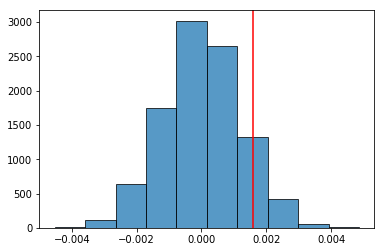

In [10]:
plt.hist(p_diffs, edgecolor='black', alpha=0.75);
plt.axvline(np.abs(actual_diff), color='red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
p_diffs = np.array(p_diffs)
(p_diffs > actual_diff).mean()

0.90039999999999998

This value is the p-value. This is the probability of finding the observed statistic or a more extreme result under the null hypothesis. Our null hypothesis stated that the two pages have equal conversion rates, so we have a two-tailed test. If we take an acceptance level to be 0.5, our p-value is not within an acceptable range, and so we must fail to reject the null hypothesis.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

In [29]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page"').query('converted == 1').converted.sum()
convert_new = df2.query('landing_page == "new_page"').query('converted == 1').converted.sum()
n_old = df2.query('landing_page == "old_page"').converted.count()
n_new = df2.query('landing_page == "new_page"').converted.count() 

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute the test statistic and p-value. 

In [30]:
sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')

(1.3109241984234394, 0.90505831275902449)

The p-value we computed here is slightly different than the prior p-value, but this still suggests we should reject the null. The z-score shows us that the differences in conversion rates for old vs new page is about 1.3 more in favor of the old page.

<a id='regression'></a>
### Part III - A regression approach




This is a perfect fit for logistic regression, since our dependent variable is bound by only two possibilities.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [32]:

df2['ab_page'] = pd.get_dummies(df['group'], drop_first=True)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [34]:
from scipy import stats
df2['intercept'] = 1
stats.chisqprob = lambda chisq, df2: stats.chi2.sf(chisq, df2)
log = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
mod = log.fit()


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [35]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 27 Jan 2018   Pseudo R-squ.:               8.077e-06
Time:                        11:43:55   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The p-value associated with ab_page is 0.19 -- the difference is due to the fact that the logistic regression p-value represents a two tailed test, where our prior p-value was for just the differences being greater.

The null hypothesis of the regression model is that the old page is better than the new page: that is, the old page has more converts than the new page. So the alternative, that we would like to prove, is that the new page really does convert more users than the old page.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

It's a good idea to explore all possibilities available in the data for correlation. Perhaps some users will convert more during certain times, or certain days, or even certain seasons.

A danger of adding additional terms into the regression model is multicorrelation. Some independent variables may have relationships with one another, and this could mislead us with the final results.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [36]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [37]:
### Create the necessary dummy variables
df_new = df_new.join(pd.get_dummies(df_new['country'], drop_first = True))
df_new.head()

country                   timestamp      group landing_page  \
user_id                                                               
834778       UK  2017-01-14 23:08:43.304998    control     old_page   
928468       US  2017-01-23 14:44:16.387854  treatment     new_page   
822059       UK  2017-01-16 14:04:14.719771  treatment     new_page   
711597       UK  2017-01-22 03:14:24.763511    control     old_page   
710616       UK  2017-01-16 13:14:44.000513  treatment     new_page   

         converted  ab_page  intercept  UK  US  
user_id                                         
834778           0        0          1   1   0  
928468           0        1          1   0   1  
822059           1        1          1   1   0  
711597           0        0          1   1   0  
710616           0        1          1   1   0

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [38]:
### Fit Your Linear Model And Obtain the Results
df_new['intercept'] = 1
stats.chisqprob = lambda chisq, df_new: stats.chi2.sf(chisq, df_new)
mod_2 = sm.Logit(df_new['converted'], df_new[['intercept', 'UK', 'US']])
mod_2.fit().summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sat, 27 Jan 2018   Pseudo R-squ.:               1.521e-05
Time:                        11:44:12   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

In [39]:
np.exp(-2.0375), np.exp(0.0507), np.exp(0.0408)

(0.13035418933417164, 1.0520072437650141, 1.0416437559600236)

Looking at the results, we can interpret the following:

The results for the UK are not statistically significant--we see that we have a p-value of 0.074, which is above our tolerance level.

Users from the US are 1.04 times as likely to convert than the same baseline.


